# Basic Classifying VAE for MNIST Database

In [1]:
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import torch
import pprint
import numpy as np
import numpy.random as random
import datetime
import matplotlib.pyplot as plt
from collections import defaultdict

import os
import sys
print("Current working dir: ", os.getcwd())
print("Initial path: ", sys.path)
sys.path.append("../")
print()
print("Updated path: ", sys.path)
from src.pytorch_cl_vae.model import ClVaeModel
print()
print("PyTorch Version ", torch.__version__)

Current working dir:  /home/seanny/classifying_autoencoders/notebooks
Initial path:  ['', '/home/seanny/catkin_ws/devel/lib/python2.7/dist-packages', '/opt/ros/kinetic/lib/python2.7/dist-packages', '/home/seanny/anaconda2/envs/python3.5/lib/python35.zip', '/home/seanny/anaconda2/envs/python3.5/lib/python3.5', '/home/seanny/anaconda2/envs/python3.5/lib/python3.5/plat-linux', '/home/seanny/anaconda2/envs/python3.5/lib/python3.5/lib-dynload', '/home/seanny/.local/lib/python3.5/site-packages', '/home/seanny/anaconda2/envs/python3.5/lib/python3.5/site-packages', '/home/seanny/roboschool', '/home/seanny/DeepRL', '/home/seanny/gym-aero', '/home/seanny/baselines', '/home/seanny/anaconda2/envs/python3.5/lib/python3.5/site-packages/IPython/extensions', '/home/seanny/.ipython']

Updated path:  ['', '/home/seanny/catkin_ws/devel/lib/python2.7/dist-packages', '/opt/ros/kinetic/lib/python2.7/dist-packages', '/home/seanny/anaconda2/envs/python3.5/lib/python35.zip', '/home/seanny/anaconda2/envs/python

## 1 - Specify parameters for to the VAE and training

In [2]:
params = {
    'batch_size': 100,
    'num_epochs': 10,
    'latent_dim': 20,
    'encoder_hidden_size': 512,
    'decoder_hidden_size': 512,
    'classifier_hidden_size': 512,
    'vae_learning_rate': 0.0001,
    'classifier_learning_rate': 0.0001,
    'log_dir': '../data/logs',
    'model_dir': '../data/models',
    'data_dir': '../data'
}

## 2 - Fetch MNIST

In [3]:
mnist = fetch_mldata('MNIST original', data_home=params['data_dir'])
mnist.data = mnist.data / 255
num_samples, input_dim = mnist.data.shape
num_classes = len(np.unique(mnist.target))
lb = preprocessing.LabelBinarizer()
lb.fit(mnist.target)
params['classes_dim'] = [num_classes]
params['original_dim'] = input_dim
print('MNIST db has been successfully loaded, stored in the: "{}"'.format(params['data_dir'] + '/mldata'))
# split data to train and test subsets
X_train, X_test, y_train, y_test = train_test_split(mnist.data, mnist.target, test_size=0.1, random_state=0)
print("| Train subset shape:{} | Test subset shape:{} |".format(X_train.shape, X_test.shape))

MNIST db has been successfully loaded, stored in the: "../data/mldata"
| Train subset shape:(63000, 784) | Test subset shape:(7000, 784) |


## 3 - Create Model

In [4]:
# Initialize ClVaeModel
dev = "cuda:0" if torch.cuda.is_available() else "cpu"
params['device'] = dev
model = ClVaeModel(**params)
print("Model successfully initialized with params: ")
pprint.PrettyPrinter(indent=4).pprint(params)
print()
print()
print("Network Architecture:")
print()
print(model)

train_losses = []
train_accuracies = []

Model successfully initialized with params: 
{   'batch_size': 100,
    'classes_dim': [10],
    'classifier_hidden_size': 512,
    'classifier_learning_rate': 0.0001,
    'data_dir': '../data',
    'decoder_hidden_size': 512,
    'device': 'cuda:0',
    'encoder_hidden_size': 512,
    'latent_dim': 20,
    'log_dir': '../data/logs',
    'model_dir': '../data/models',
    'num_epochs': 10,
    'original_dim': 784,
    'vae_learning_rate': 0.0001}


Network Architecture:



## 4 - Train

In [8]:
save_each_steps = 500

# Train loop
train_step_i = 0
for epoch in range(params['num_epochs']):
    print('\nepoch {} out of {}'.format(epoch + 1, params['num_epochs']))
    for i in range(X_train.shape[0] // params['batch_size']):
        # Sample batch
        idx = random.choice(np.arange(0, X_train.shape[0]), params['batch_size'])
        x_batch = torch.from_numpy(X_train[idx]).float().to(torch.device(dev))
        y_batch = lb.transform(y_train[idx])
        y_batch = [torch.from_numpy(y_batch).float().to(torch.device(dev))]
        step_losses, step_accuracies = model.train_step(x_batch, y_batch)

#         step_losses = [loss.sum().detach().numpy() for loss in step_losses]
        # step_losses = Losses(*step_losses)
        # step_accuracies = Accuracies(*step_accuracies)

        train_losses.append(step_losses)
        train_accuracies.append(step_accuracies)

        train_step_i += 1

        print("\r|train step: {} | rec loss: {:.4f} | z_dkl loss: {:.4f} | class loss: {:.4f}"
              " | w_dkl loss: {:.4f} | class_accuracy: {:.4f} |".format(
            train_step_i, *step_losses, *step_accuracies
            ), end='')
        if train_step_i % 100 == 0:
            print()
        if train_step_i % save_each_steps == 0:
            dt = str(datetime.datetime.now().strftime("%m_%d_%Y_%I_%M_%p"))
            fname = params['model_dir'] + '/cl_vae_mnist_{}.pt'.format(dt)
            model.save_ckpt(fname)
model.save_ckpt(params['model_dir'] + '/cl_vae_mnist_last.pt')
print('*****Finished with the final loss: ', step_losses)


epoch 1 out of 10
|train step: 100 | rec loss: 0.2187 | z_dkl loss: 0.0214 | class loss: 1.9354 | w_dkl loss: 0.1189 | class_accuracy: 0.7200 |
|train step: 200 | rec loss: 0.2046 | z_dkl loss: 0.0039 | class loss: 1.8902 | w_dkl loss: 0.1161 | class_accuracy: 0.8200 |
|train step: 300 | rec loss: 0.2177 | z_dkl loss: 0.0018 | class loss: 1.8692 | w_dkl loss: 0.1506 | class_accuracy: 0.8100 |
|train step: 400 | rec loss: 0.2042 | z_dkl loss: 0.0018 | class loss: 1.8947 | w_dkl loss: 0.0939 | class_accuracy: 0.8100 |
|train step: 500 | rec loss: 0.1953 | z_dkl loss: 0.0016 | class loss: 1.8339 | w_dkl loss: 0.0575 | class_accuracy: 0.8600 |
|train step: 600 | rec loss: 0.2106 | z_dkl loss: 0.0006 | class loss: 1.8499 | w_dkl loss: 0.1660 | class_accuracy: 0.8200 |
|train step: 630 | rec loss: 0.2071 | z_dkl loss: 0.0038 | class loss: 1.8932 | w_dkl loss: 0.1065 | class_accuracy: 0.8000 |
epoch 2 out of 10
|train step: 700 | rec loss: 0.2036 | z_dkl loss: 0.0017 | class loss: 1.8594 | w

|train step: 5600 | rec loss: 0.1927 | z_dkl loss: 0.0328 | class loss: 1.7960 | w_dkl loss: 0.1186 | class_accuracy: 0.8800 |
|train step: 5670 | rec loss: 0.1966 | z_dkl loss: 0.0038 | class loss: 1.8116 | w_dkl loss: 0.0344 | class_accuracy: 0.8700 |
epoch 10 out of 10
|train step: 5700 | rec loss: 0.2053 | z_dkl loss: 0.0213 | class loss: 1.8151 | w_dkl loss: 0.1076 | class_accuracy: 0.8400 |
|train step: 5800 | rec loss: 0.2000 | z_dkl loss: 0.0060 | class loss: 1.8130 | w_dkl loss: 0.0371 | class_accuracy: 0.8400 |
|train step: 5900 | rec loss: 0.2014 | z_dkl loss: 0.0023 | class loss: 1.8609 | w_dkl loss: 0.0584 | class_accuracy: 0.7700 |
|train step: 6000 | rec loss: 0.1979 | z_dkl loss: 0.0045 | class loss: 1.8246 | w_dkl loss: 0.1265 | class_accuracy: 0.8600 |
|train step: 6100 | rec loss: 0.2027 | z_dkl loss: 0.0181 | class loss: 1.8393 | w_dkl loss: 0.0962 | class_accuracy: 0.8100 |
|train step: 6200 | rec loss: 0.1983 | z_dkl loss: 0.0024 | class loss: 1.8078 | w_dkl loss:

## 5 - Show losses graph

No handles with labels found to put in legend.


('rec_loss', 'z_dkl_loss', 'class_loss_0', 'w_dkl_loss_0')
tensor(0.6956, device='cuda:0') tensor(1.00000e-02 *
       7.1203, device='cuda:0') tensor(2.3001, device='cuda:0') tensor(1.00000e-02 *
       1.4397, device='cuda:0')


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


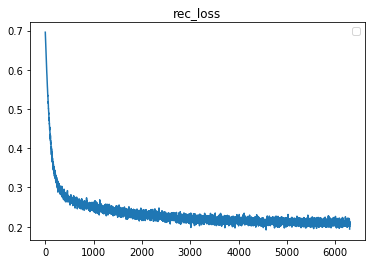

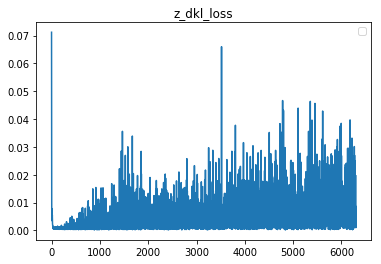

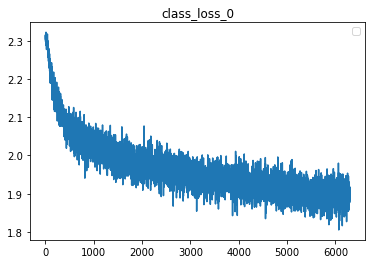

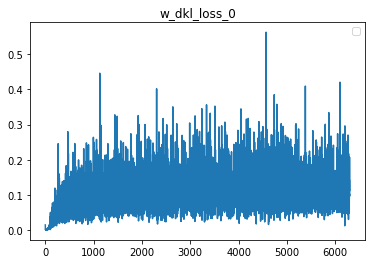

In [6]:
%matplotlib inline
losses = defaultdict(list)
losses_names = train_losses[0]._fields
print(losses_names)
step_loss = train_losses[0]
print(*step_loss)
for i, loss_name in enumerate(losses_names):
    losses[loss_name] = [l[i] for l in train_losses]
    plt.figure()
    plt.title(loss_name)
    plt.plot(losses[loss_name])
    plt.legend()
plt.show()